In [1]:
!pip install gymnasium[classic-control] torch numpy matplotlib tqdm

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class MultiTaskWrapper:
    def __init__(self):
        self.envs = {
            0: gym.make("CartPole-v1"),
            1: gym.make("Acrobot-v1"),
            2: gym.make("MountainCar-v0"),
            3: gym.make("Pendulum-v1")
        }
        self.task_names = ["CartPole", "Acrobot", "MountainCar", "Pendulum"]

    def get_state(self, task_id, obs):
        # 1. Pad observation to size 6
        padded = np.zeros(6)
        padded[:len(obs)] = obs
        # 2. Add One-Hot Task ID (size 4)
        one_hot = np.zeros(4)
        one_hot[task_id] = 1
        return np.concatenate([padded, one_hot])

    def map_action(self, task_id, network_idx):
        """Maps 11 network outputs to environment actions"""
        if task_id == 0: # CartPole (0 or 1)
            return 0 if network_idx < 5 else 1
        elif task_id == 1 or task_id == 2: # Acrobot/MountainCar (0, 1, or 2)
            if network_idx < 4: return 0
            if network_idx < 7: return 1
            return 2
        elif task_id == 3: # Pendulum (Continuous -2 to 2)
            return [ -2.0 + (network_idx / 10.0) * 4.0 ]

In [3]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 128), # 6 padded states + 4 task IDs
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 11) # 11 discrete action bins
        )
    def forward(self, x): return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, ns, d): self.buffer.append((s, a, r, ns, d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(lambda x: torch.FloatTensor(np.array(x)), zip(*batch))

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initializing tracking lists
all_rewards = []
all_tasks = []

def plot_res(rewards, tasks):
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    unique_tasks = ["CartPole", "Acrobot", "MountainCar", "Pendulum"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Blue, Orange, Green, Red

    for i, task in enumerate(unique_tasks):
        # Filtering rewards for specific task
        task_rewards = [r for r, t in zip(rewards, tasks) if t == task]
        task_episodes = [idx for idx, t in enumerate(tasks) if t == task]

        if task_rewards:
            # Plot raw data (faded)
            plt.plot(task_episodes, task_rewards, color=colors[i], alpha=0.2)

            # Plot Moving Average (thick line)
            if len(task_rewards) > 10:
                ma = np.convolve(task_rewards, np.ones(10)/10, mode='valid')
                plt.plot(task_episodes[9:], ma, label=f"{task} (Smooth)", color=colors[i], linewidth=2)

    plt.title('Multi-Task DQN Learning Progress')
    plt.xlabel('Global Episode')
    plt.ylabel('Total Reward')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [5]:
from google.colab import drive
import os

#Mount Google Drive
drive.mount('/content/drive')

#Creating specific folder
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/GeneralistDQN/"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    print(f"Created folder at: {SAVE_PATH}")

Mounted at /content/drive


In [6]:
def save_model(episode, name="generalist_dqn.pt"):
    """Saves the weights of the policy network to your Google Drive"""
    path = os.path.join(SAVE_PATH, name)
    torch.save({
        'episode': episode,
        'model_state_dict': policy_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon
    }, path)
    print(f" Progress saved at Episode {episode} to Drive")

def load_model(name="generalist_dqn.pt"):
    """Loads weights from Google Drive so you can resume training"""
    global epsilon
    path = os.path.join(SAVE_PATH, name)
    if os.path.exists(path):
        checkpoint = torch.load(path)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        target_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epsilon = checkpoint['epsilon']
        print(f" Loaded model from episode {checkpoint['episode']}")
        return checkpoint['episode']
    else:
        print(" No saved model found. Starting from scratch.")
        return 0

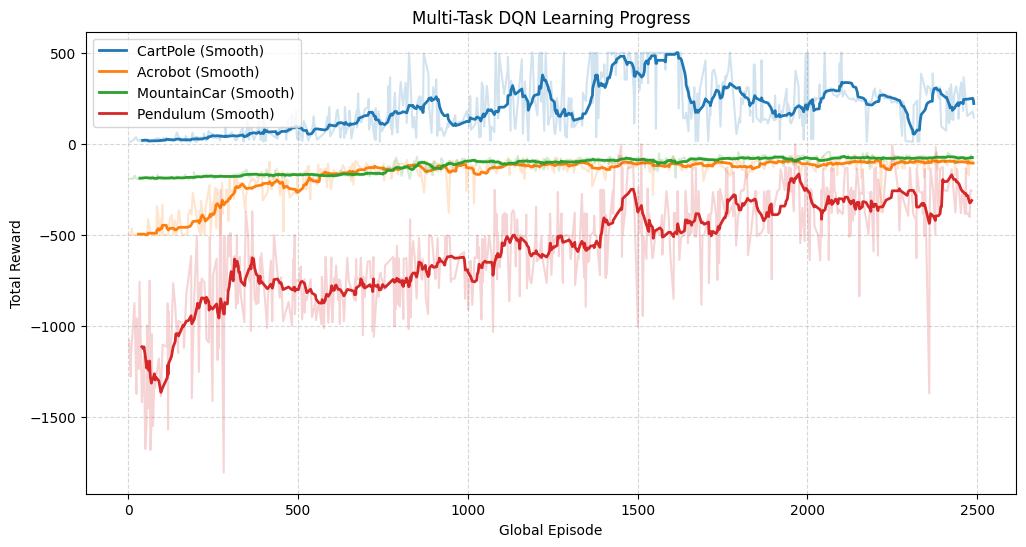

In [7]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

# THE BRAIN (256 Neurons)
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
    def forward(self, x): return self.net(x)

# THE MEMORY
class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, ns, d): self.buffer.append((s, a, r, ns, d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(lambda x: torch.FloatTensor(np.array(x)), zip(*batch))

# THE MULTI-TASK WRAPPER
class MultiTaskWrapper:
    def __init__(self):
        self.envs = {
            0: gym.make("CartPole-v1"),
            1: gym.make("Acrobot-v1"),
            2: gym.make("MountainCar-v0"),
            3: gym.make("Pendulum-v1")
        }
        self.task_names = ["CartPole", "Acrobot", "MountainCar", "Pendulum"]

    def get_state(self, task_id, obs):
        padded = np.zeros(6)
        padded[:len(obs)] = obs
        one_hot = np.zeros(4)
        one_hot[task_id] = 1
        return np.concatenate([padded, one_hot])

    def map_action(self, task_id, network_idx):
        if task_id == 0: return 0 if network_idx < 5 else 1
        elif task_id == 1 or task_id == 2:
            if network_idx < 4: return 0
            if network_idx < 7: return 1
            return 2
        elif task_id == 3: return [-2.0 + (network_idx / 10.0) * 4.0]

# CONFIGURATION
LR = 0.0005
GAMMA = 0.99
BATCH_SIZE = 64
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 0.9985
epsilon = EPS_START

wrapper = MultiTaskWrapper()
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayBuffer()

all_rewards = []
all_tasks = []

# THE DOUBLE DQN TRAINING LOOP
for episode in range(2500):
    task_id = random.randint(0, 3)
    task_name = wrapper.task_names[task_id]
    env = wrapper.envs[task_id]

    obs, _ = env.reset()
    state = wrapper.get_state(task_id, obs)
    total_reward = 0

    for t in range(500):
        if random.random() < epsilon:
            action_idx = random.randint(0, 10)
        else:
            with torch.no_grad():
                action_idx = policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()

        env_action = wrapper.map_action(task_id, action_idx)
        next_obs, reward, done, truncated, _ = env.step(env_action)

        # Reward Shaping for MountainCar
        if task_id == 2:
            reward = reward + (15 * abs(next_obs[1])) + (next_obs[0] + 0.5)

        next_state = wrapper.get_state(task_id, next_obs)
        memory.push(state, action_idx, reward, next_state, done or truncated)
        state = next_state
        total_reward += reward

        if len(memory.buffer) > BATCH_SIZE:
            b_s, b_a, b_r, b_ns, b_d = memory.sample(BATCH_SIZE)

            # DDQN LOGIC START
            # Using Policy Net to pick the best action for the NEXT state
            next_actions = policy_net(b_ns).argmax(1).unsqueeze(1)

            # Using Target Net to evaluate the value of THAT specific action
            q_values = policy_net(b_s).gather(1, b_a.long().unsqueeze(1))
            with torch.no_grad():
                next_q = target_net(b_ns).gather(1, next_actions).squeeze(1)
                expected_q = b_r + (GAMMA * next_q * (1 - b_d))

            loss = nn.MSELoss()(q_values.squeeze(), expected_q)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        if done or truncated: break

    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    all_rewards.append(total_reward)
    all_tasks.append(task_name)

    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        plot_res(all_rewards, all_tasks)

In [12]:
!pip install moviepy

import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import os
import glob
from moviepy.editor import VideoFileClip, clips_array
from IPython.display import HTML
import base64


video_files = []
tasks = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]

print("🎬 Starting the Victory Lap... Recording all 4 environments.")

for i, task_name in enumerate(tasks):
    # Setup env
    temp_env = gym.make(task_name, render_mode="rgb_array")
    temp_env = RecordVideo(temp_env, video_folder="./grid_temp",
                          name_prefix=f"grid_{i}",
                          episode_trigger=lambda x: True)

    obs, _ = temp_env.reset()
    done = False
    truncated = False

    while not (done or truncated):
        state = wrapper.get_state(i, obs)
        with torch.no_grad():
            action_idx = policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()

        env_action = wrapper.map_action(i, action_idx)
        obs, reward, done, truncated, _ = temp_env.step(env_action)

    temp_env.close()

    # Finding the newly created video path
    path = max(glob.glob(f'./grid_temp/grid_{i}*.mp4'), key=os.path.getctime)
    video_files.append(path)
    print(f" Recorded {task_name}")


print(" Stitching videos into a 2x2 grid...")

clip0 = VideoFileClip(video_files[0]).margin(10)
clip1 = VideoFileClip(video_files[1]).margin(10)
clip2 = VideoFileClip(video_files[2]).margin(10)
clip3 = VideoFileClip(video_files[3]).margin(10)

# Creating the 2x2 array
grid = clips_array([[clip0, clip1],
                    [clip2, clip3]])

final_video_path = "agent_grid_view.mp4"
grid.write_videofile(final_video_path, fps=30, logger=None)


video_data = open(final_video_path, "rb").read()
encoded = base64.b64encode(video_data)
display(HTML(data=f'''<video width="800" controls autoplay loop>
    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
</video>'''))

 Starting the Victory Lap... Recording all 4 environments.
 Recorded CartPole-v1
 Recorded Acrobot-v1
 Recorded MountainCar-v0
 Recorded Pendulum-v1
 Stitching videos into a 2x2 grid...


  warnings.warn("Warning: in file %s, "%(self.filename)+

